In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
from pathlib import Path
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
# API = 'B7Y1195218DZFJGJ'
#https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol=PZA&apikey=[B7Y1195218DZFJGJ]&datatype=csv

In [3]:
csvpath = Path("Resources/daily_QQQ.csv")
QQQ = pd.read_csv(csvpath)

In [4]:
# Sort DataFrame by date
QQQ = QQQ.sort_values('timestamp')

# Double check the result
QQQ.head()

,timestamp,open,high,low,close,volume
5292,1/10/2000,182.00,187.90,179.900,185.00,14837800
5039,1/10/2001,56.13,60.38,55.750,60.19,74258300
4791,1/10/2002,41.17,41.54,40.680,41.38,75548000
4539,1/10/2003,26.35,27.26,26.220,27.10,82594300
4036,1/10/2005,38.45,38.87,38.389,38.53,88764200


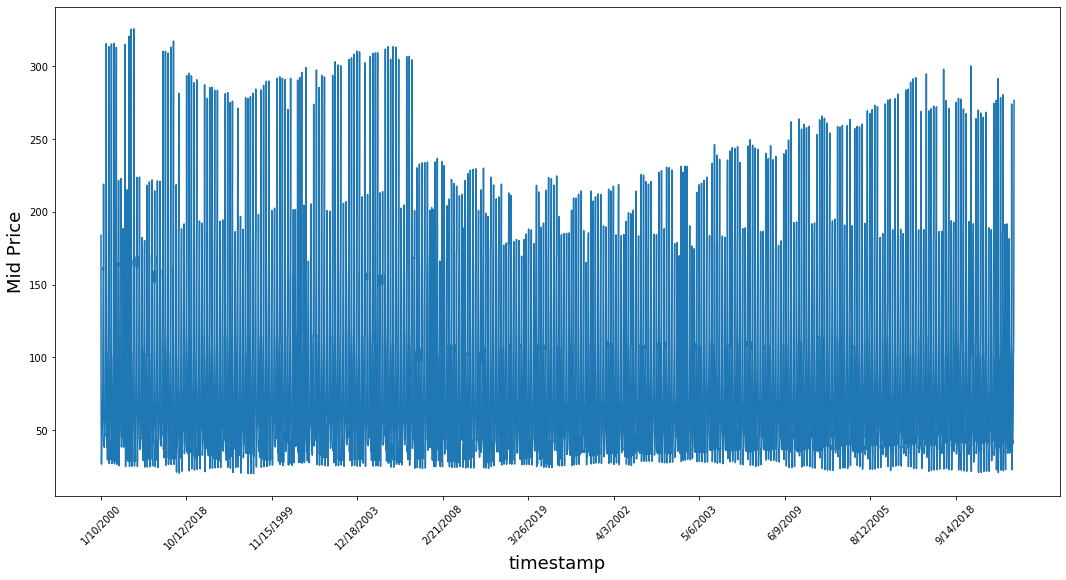

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(QQQ.shape[0]),(QQQ['low']+QQQ['high'])/2.0)
plt.xticks(range(0,QQQ.shape[0],500),QQQ['timestamp'].loc[::500],rotation=45)
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = QQQ.loc[:,'high'].to_numpy()
low_prices = QQQ.loc[:,'low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [7]:
train_data = mid_prices[:2264]
test_data = mid_prices[2264:]

In [8]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 1100
for di in range(4400, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
#scaler.fit(train_data[di+smoothing_window_size:,:])
#train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [15]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
#test_data = scaler.transform(test_data).reshape(-1)

In [16]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0
gamma = 0.1
for ti in range(4400):
  #EMA = gamma*train_data[ti] + (1-gamma)*EMA
  #train_data[ti] = EMA

# Used for visualization and test purposes
    all_mid_data = np.concatenate([train_data,test_data], axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [17]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = QQQ.loc[pred_idx,'timestamp']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 2152.10770


In [61]:
plt.figure(figsize = (18,9))
plt.plot(range(QQQ.shape[0]), all_mid_data, label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('timestamp')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

NameError: name 'all_mid_data' is not defined

<Figure size 1296x648 with 0 Axes>

In [57]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.36402


In [60]:
plt.figure(figsize = (18,9))
plt.plot(range(QQQ.shape[0]),all_mid_data, color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

NameError: name 'all_mid_data' is not defined

<Figure size 1296x648 with 0 Axes>

In [62]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [ 0.3639   88.49229  84.30395  86.23466  89.799255]

	Output: [ 4.315238 86.7392   84.3759   87.08434  91.253784]


Unrolled index 1
	Inputs:  [ 1.040595 87.752464 84.23393  85.994736 90.28795 ]

	Output: [ 5.660595 86.97642  84.86829  86.49299  91.82535 ]


Unrolled index 2
	Inputs:  [ 1.9664395 87.148384  84.3759    86.09108   90.79634  ]

	Output: [ 5.660595 86.7392   86.61431  86.09108  91.82535 ]


Unrolled index 3
	Inputs:  [ 3.072764 86.7618   84.86829  86.49299  91.253784]

	Output: [ 7.081864 87.34108  88.60321  87.74591  91.87999 ]


Unrolled index 4
	Inputs:  [ 4.315238 86.7392   85.649345 87.08434  91.6116  ]

	Output: [ 7.081864 86.97642  85.649345 87.74591  91.6116  ]


In [66]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [69]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

ops.reset_default_graph() 

In [73]:
from tensorflow.python.keras.layers import  Input, Embedding, Dot, Reshape, Dense
from tensorflow.python.keras.models import Model

In [74]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

AttributeError: module 'tensorflow' has no attribute 'placeholder'